In [387]:
import math 

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BASE_PATH = '/Users/vinay/ub/spring-22/CSE573-CVIP/BackgroundStitching/images'

In [1568]:
sift = cv2.SIFT_create()

class Recognition:
    def __init__(self, feature_detector):
        self.feature_detector = feature_detector
        self.bf = cv2.BFMatcher()
        
    def get_features(self, img):
        return self.feature_detector.detectAndCompute(img, None)
        
    def match_bf(self, img1, img2, n=20, l_thickness=2):
        kp_1, dsc_1 = self.get_features(img1)
        kp_2, dsc_2 = self.get_features(img2)
        
        matches = self.bf.match(dsc_1, dsc_2)
        matches = sorted(matches, key = lambda x:x.distance, reverse=False)

        img = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:n+1], None, flags=2, matchesThickness=l_thickness)
        
        return (matches, (kp_1, kp_2)), img
    
    def match_f(self, img1, img2, n=20, r=0.7, l_thickness=2):
        kp_1, dsc_1 = self.get_features(img1)
        kp_2, dsc_2 = self.get_features(img2)
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(dsc_1, dsc_2, k=2)
        good_matches = []
        
        for p, q in matches:
            if p.distance < r * q.distance:
                good_matches.append(p)
        
        img = cv2.drawMatches(img1, kp_1, img2, kp_2, good_matches[:n+1], None, flags=2, matchesThickness=l_thickness)
        
        return (good_matches, (kp_1, kp_2)), img
    
recog = Recognition(sift)

def compute_homography(args, img1, img2, min_matches=5):
    img1 = img1.copy()
    img2 = img2.copy()
    (matches, (kp1, kp2)) = args
    
    assert len(matches) >= min_matches, f'Need at least {min_matches} matches'

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape
    pts = np.float32([ [0, 0],[0, h-1],[w-1, h-1],[w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, homography)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2,
    )
    op = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
    
    return dst, mask, homography, op
        
    
def transform_c(coordinates, homography):
    x, y, w, h = coordinates
    src = np.float32([[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]]).reshape(-1, 1, 2)
    
    dst = cv2.perspectiveTransform(src, homography)
    l, _, _ = dst.shape
    dst = dst.reshape((l, 2))
    # print(dst)
    # print('\n')
    # print(homography)
    
    min_x, max_x = np.min(dst[:, 0]), np.max(dst[:, 0])
    min_y, max_y = np.min(dst[:, 1]), np.max(dst[:, 1])
    
    new_x = int(np.floor(min_x))
    new_y = int(np.floor(min_y))
    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))
    
    return new_x, new_y, new_w, new_h

def shape(img):
    s = img.shape
    a = None
    if len(s) == 3:
        h, w, a = img.shape
    else:
        h, w = img.shape
        
    return h, w, a

def get_new_c(c, homography):
    return np.floor(cv2.perspectiveTransform(np.float32(c).reshape(-1, 1, 2), homography))

def img2c(img):
    size = img.shape
    return (0, 0, size[1], size[0])

def translate_homography(dx, dy, H):
    dx, dy = abs(dx) if dx < 0 else 0, abs(dy) if dy < 0 else 0
    transform = np.float32(
        [
            [1, 0, dx],
            [0, 1, dy],
            [0, 0,  1],
        ]
    )
    new_h = transform.dot(H)
    return new_h, (dx, dy)

def resize(img, factor):
    h, w = img.shape
    op = cv2.resize(img, (int(w*factor), int(h*factor)))
    return op

def show(img, dpi=100, disable_axis=True, color=True):
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    plt.figure(dpi=dpi)
    plt.imshow(img, cmap='gray')
    
    if disable_axis:
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

In [693]:
# img1_c = cv2.imread(f'{BASE_PATH}/left_k.JPG')
# img2_c = cv2.imread(f'{BASE_PATH}/right_k.JPG')

img1_c = cv2.imread(f'{BASE_PATH}/t1_1.png')
img2_c = cv2.imread(f'{BASE_PATH}/t1_2.png')

# img1_c = cv2.imread(f'{BASE_PATH}/left_1.png')
# img2_c = cv2.imread(f'{BASE_PATH}/right_1.png')

# img1_c = cv2.imread(f'{BASE_PATH}/left_2.png')
# img2_c = cv2.imread(f'{BASE_PATH}/right_2.png')

img1 = cv2.cvtColor(img1_c, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_c, cv2.COLOR_BGR2GRAY)

h1, w1 = img1.shape
h2, w2 = img2.shape

scale_factor = 1.0

if scale_factor != 1.0:
    img1 = resize(img1, scale_factor)
    img2 = resize(img2, scale_factor)

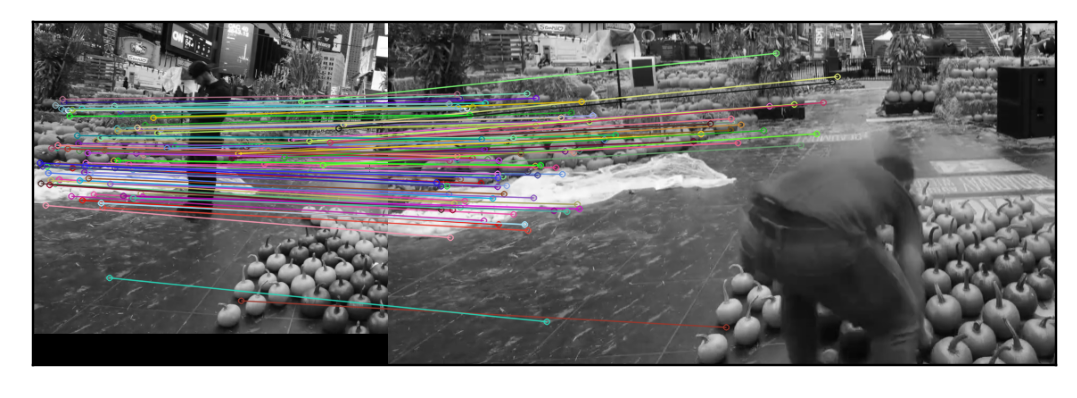

In [561]:
(matches, (kp1, kp2)), match_img = recog.match_bf(img1, img2, 100, 1)
show(match_img, dpi=220)

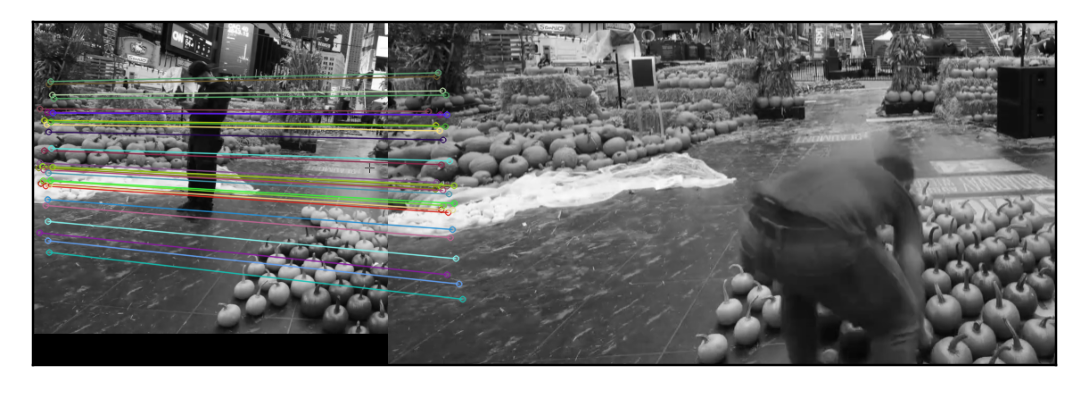

In [694]:
(matches, (kp1, kp2)), match_img = recog.match_f(img1, img2, 30, 0.60, 1)
show(match_img, dpi=220)

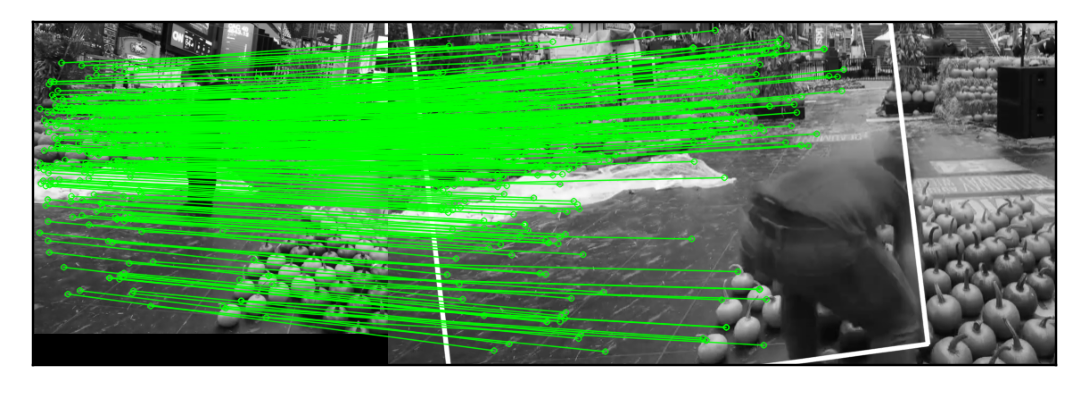

In [695]:
dst, mask, H, h_img = compute_homography((matches, (kp1, kp2)), img1, img2)
show(h_img, dpi=220)

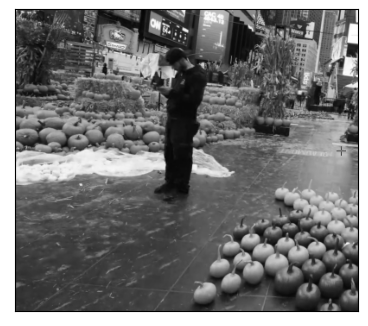

In [696]:
show(img1, dpi=100)

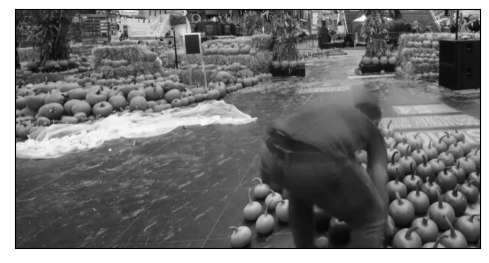

In [697]:
show(img2, dpi=100)

In [662]:
get_new_c([[0, 0]], new_H)

array([[[20., 73.]]], dtype=float32)

In [663]:
get_new_c([[img1.shape[1], 0]], new_H)

array([[[1405., -118.]]], dtype=float32)

img1: (350, 398)
dx:20, dy:-101
x:20, y:0
tx:0, ty:101


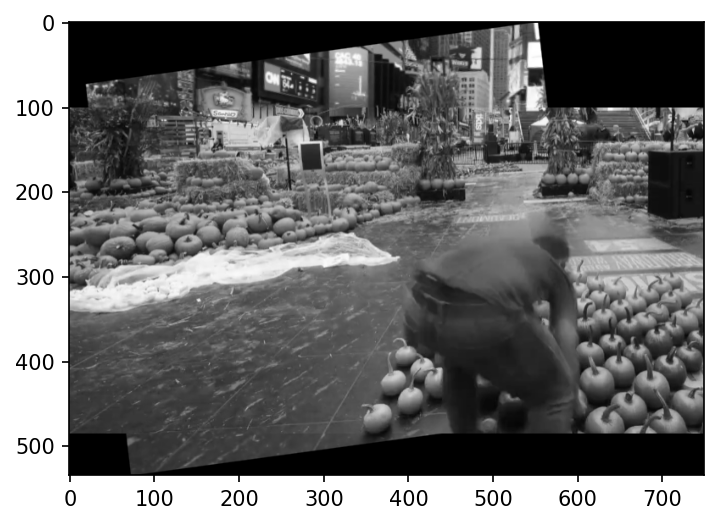

In [1987]:
dx, dy, dw, dh = transform_c(img2c(img1), H)
print(f'img1: {img1.shape}')
print(f'dx:{dx}, dy:{dy}')
new_H, (tx, ty) = translate_homography(dx, dy, H)
x, y, w, h = transform_c(img2c(img1), new_H)
print(f'x:{x}, y:{y}')
print(f'tx:{tx}, ty:{ty}')
width, height = max(tx + img2.shape[1], x+w), max(ty + img2.shape[0], y+h)


result = cv2.warpPerspective(img1, new_H, (width, height))
result_c = result.copy()
result_c[ty:ty+img2.shape[0], tx:tx+img2.shape[1]] = img2
temp = np.zeros((height, width), dtype=np.uint8)
temp[ty:ty+img2.shape[0], tx:tx+img2.shape[1]] = img2

# result = cv2.warpPerspective(img1_c, new_H, (width, height))
# result_c = result.copy()
# result_c[ty:ty+img2.shape[0], tx:tx+img2.shape[1]] = img2_c
# temp = np.zeros((height, width, 3), dtype=np.uint8)
# temp[ty:ty+img2.shape[0], tx:tx+img2.shape[1], :] = img2_c

show(result_c, dpi=150, disable_axis=False)

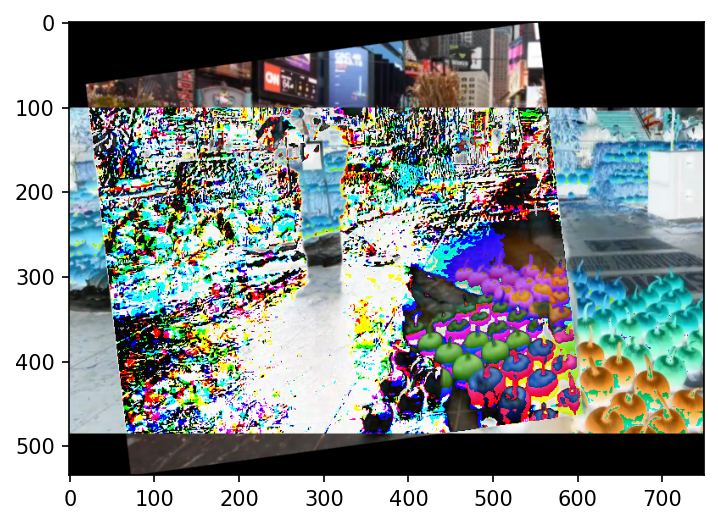

In [1420]:
show(result-temp, dpi=150, disable_axis=False)

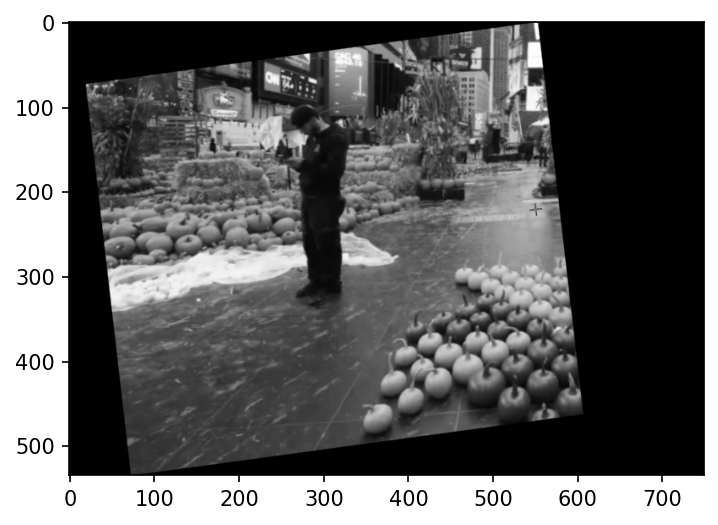

In [1988]:
show(result, dpi=150, disable_axis=False)

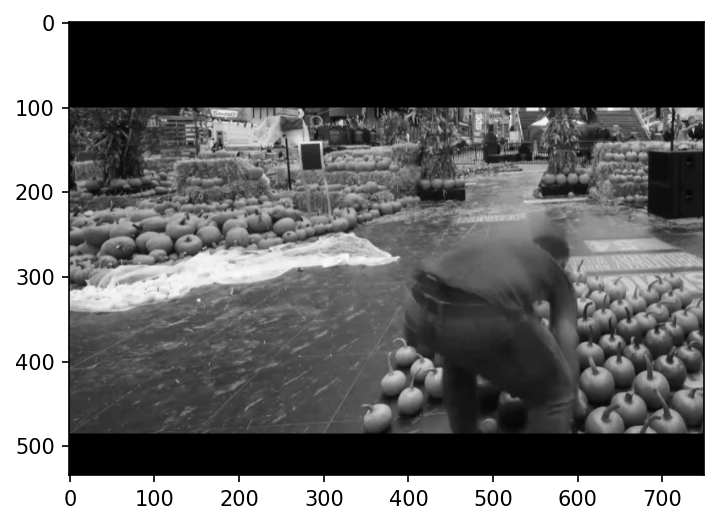

In [1989]:
show(temp, dpi=150, disable_axis=False)

In [1990]:
mask = np.logical_and(
    result,
    temp,
).astype('int8')
intersection = np.argwhere(mask == True)

max_dims = np.max(intersection, axis=0)
min_dims = np.min(intersection, axis=0)

y_max, x_max = max_dims[0], max_dims[1]
y_min, x_min = min_dims[0], min_dims[1]

x_max, y_max, x_min, y_min

(606, 485, 22, 101)

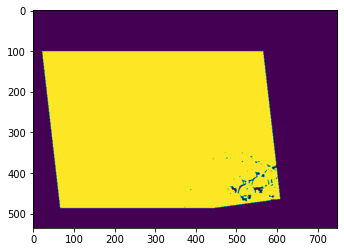

In [1895]:
plt.imshow(mask[:,:,2])

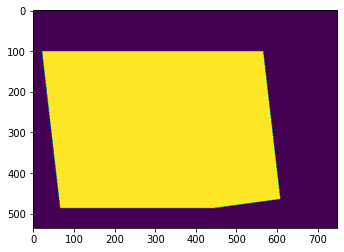

In [1991]:
plt.imshow(mask)

In [1992]:
mask.shape, result.shape

((535, 749), (535, 749))

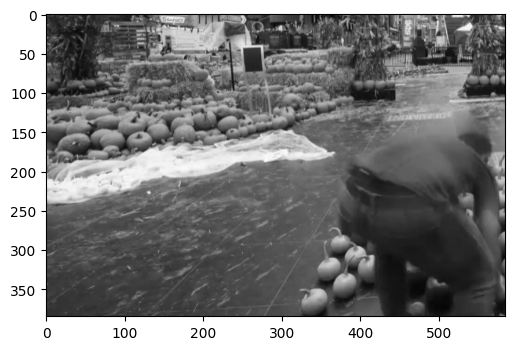

In [1993]:
show(result_c[y_min:y_max+1, x_min:x_max+1], disable_axis=False)

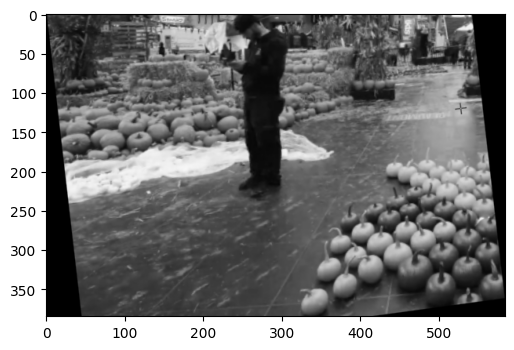

In [1994]:
show(result[y_min:y_max+1, x_min:x_max+1], disable_axis=False)

In [1995]:
result[y_min:y_max+1, x_min:x_max+1][:, 0].shape

(385,)

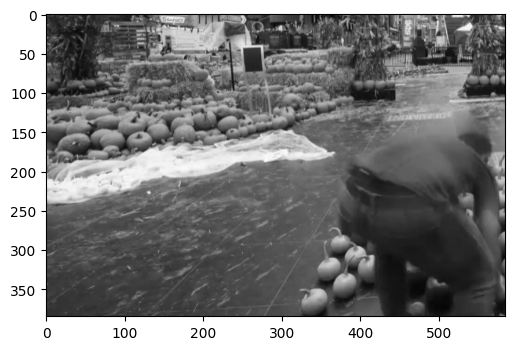

In [1996]:
show(temp[y_min:y_max+1, x_min:x_max+1], disable_axis=False)

In [1997]:
k = 1
sum(result[y_min:y_max+1, x_min:x_max+1][:, k] == 0.0), sum(temp[y_min:y_max+1, x_min:x_max+1][:, k] == 0.0)

(375, 0)

In [1900]:
def diff(img1, img2, thresh):
    img1 = cv2.bilateralFilter(img1, 90, 75, 75)
    img2 = cv2.bilateralFilter(img2, 90, 75, 75)
    
    h, w, _ = shape(img1)
    res = []
    for i in range(w):
        # x = np.abs((img1[:, i] - img2[:, i])).mean()
        x = np.abs((img2[:, i] - img1[:, i])).mean()
        if x < thresh:
            res.append(x)
        else:
            res.append(255)
        
    temp = np.array([res] * 500)
    temp.reshape(-1, 500)
    return np.uint8(temp)

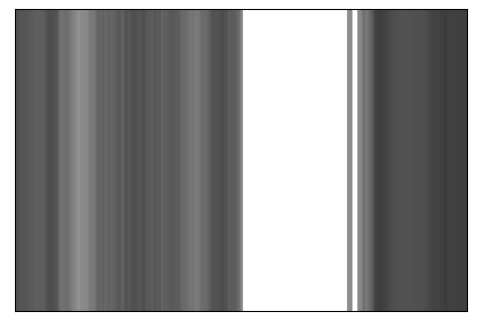

In [806]:
show(diff(result, temp, 150))

In [1614]:
def fill(img1, img2):
    h, w, _ = shape(img1)
    
    for i in range(w):
        n1 = sum(img1[:, i] == 0.0)
        n2 = sum(img2[:, i] == 0.0)
        
        if n1 < n2:
            img2[:, i] = img1[:, i]
        elif n1 > n2:
            img1[:, i] = img2[:, i]
            
    return img1, img2

In [2108]:
def apply_mask(mask, img1, img2, p=0.95):
    # print(f'img1: {shape(img1)}, img2: {shape(img2)}, mask: {shape(mask)}')
    h, w, a = shape(img1)
    if a:
        img = np.zeros((h, w, a))
    else:
        img = np.zeros((h, w))
    
    for i in range(h):
        for j in range(w):
            if mask[i, j]:
                if img2[i, j] == 0:
                    img[i, j] = img1[i, j]
                else:
                    img[i, j] = img2[i, j] * p + img1[i, j] * (1-p)
            else:
                if img1[i, j] == 0:
                    img[i, j] = img2[i, j]
                else:
                    img[i, j] = img1[i, j] * p + img2[i, j] * (1-p)
            
    return img
    
    # print('apply mask')
    # plt.imshow(mask)
    # plt.imshow(np.logical_not(mask), cmap='gray')
    # return img1 * mask + img2 * np.logical_not(mask)  
    # return img1 * np.logical_not(mask) + img2 * mask

In [2109]:
def select(img1, img2, mask, thresh=5):
    h, w, a = shape(img1)
    # print(f'img1: {shape(img1)}, img2: {shape(img2)}, mask: {shape(mask)}')
    if a:
        img_mask = np.ones((h, w, a))
    else:
        img_mask = np.ones((h, w))
    res = []
    l = []
    
    for p in range(w):
        n1 = (img1[:, p] == 0.0).sum()
        n2 = (img2[:, p] == 0.0).sum()
        
        if n1 > 0 or n2 > 0:
            break
            
        res.append(img1[:, i])
    
    for i in range(p, w):
        n1 = (img1[:, i] == 0).sum()
        n2 = (img2[:, i] == 0).sum()
       
        if i == p:
            if n1 < n2:
                ref_col = img1[:, i]
                last = 1
                flag = False
                col = 1
            else:
                ref_col = img2[:, i]
                last = 2
                flag = True
                col = 2
        
        else:
            i1w = img1[:, i]
            i2w = img2[:, i]
            
            m1 = (img1[:, i] != 0).sum()
            m2 = (img2[:, i] != 0).sum()

            # print(i, mask[:, i].sum())

            d1 = int(((i1w * mask[:, i] - ref_col * mask[:, i-1])).sum())
            d2 = int(((i2w * mask[:, i] - ref_col *  mask[:, i-1])).sum())

            # print(n1, n2)
            
            # d1 = int(((i1w - ref_col)).sum())
            # d2 = int(((i2w - ref_col)).sum())
            
            # if m1 != 0 and m2 != 0:
            #     d1 /= m1
            #     d2 /= m2

            # print(f'i:{i}, img:{col}, d1:{d1}, d2:{d2}, {(d1 - d2)}')

            if d1 < d2:
                if last == 2:
                    # print(f'i:{i}, img:{col}, d1:{d1}, d2:{d2}, {(d1 - d2)}')
                    if l and i - l[-1] < thresh:
                        # print('hi', thresh)
                        l.pop()
                    else:
                        l.append(i)
                    last = 1
                ref_col = i1w
                col = 1
                res.append(i1w)

            else:
                if last == 1:
                    # print(f'i:{i}, img:{col}, d1:{d1}, d2:{d2}, {(d1 - d2)}')
                    if l and i - l[-1] < thresh:
                        # print('hi', thresh)
                        l.pop()
                    else:
                        l.append(i)
                    last = 2
                ref_col = i2w
                col = 2
                res.append(i2w)
                
            # if n1 < n2:
            #     ref_col = i1w
            #     col = 1
            # else:
            #     ref_col = i2w
            #     col = 2
                    
    l.append(i)
    k = 0
    
    # print(flag)
    for x in l[1:]:
        img_mask[:, k:x+1] = flag
        flag = not flag
        k = x
        
    return l, img_mask, res

In [2110]:
def get_obj_x(img1, img2, x_min, y_min, x_max, y_max, mask, thresh=3):
    h, w, a = shape(img1)
        
    x_min_n = max(x_min-10, 0)
    y_min_n = max(y_min-10, 0)
    x_max_n = min(x_max+10, w)
    y_max_n = min(y_max+10, h)
    
    img1 = img1[y_min_n:y_max_n+1, x_min_n:x_max_n+1]
    img2 = img2[y_min_n:y_max_n+1, x_min_n:x_max_n+1]
    mask = mask[y_min_n:y_max_n+1, x_min_n:x_max_n+1]
    
    l, main_mask, t_res = select(img1, img2, mask=mask, thresh=thresh)
    k = 0
    temp = []
    
    for x in l[1:]:
        sub_img1 = img1[:, k:x+1]
        sub_img2 = img2[:, k:x+1]
        new_mask = mask[:, k:x+1]
        
        if a:
            sub_img1 = sub_img1.transpose((1,0,2))
            sub_img2 = sub_img2.transpose((1,0,2))
            new_mask = new_mask.transpose((1,0,2))
        else:
            sub_img1 = sub_img1.T
            sub_img2 = sub_img2.T
            new_mask = new_mask.T
        
        _, sub_mask, _ = select(
            sub_img1,
            sub_img2,
            new_mask,
            thresh=thresh,
        )
            
        if a:
            sub_mask = sub_mask.transpose((1,0,2))
            main_mask[:, k:x+1] = sub_mask
            sub_img1 = sub_img1.transpose((1,0,2))
            sub_img2 = sub_img2.transpose((1,0,2))
        else:
            sub_mask = sub_mask.T
            sub_img1 = sub_img1.T
            sub_img2 = sub_img2.T
            main_mask[:, k:x+1] = sub_mask
            
        temp.append(
            (
                _,
                np.uint8(
                    apply_mask(
                        sub_mask,
                        sub_img1,
                        sub_img2,
                    ),
                ),
            ),
        )
        
        k = x
        
    res = apply_mask(main_mask, img1, img2)
    # res = res[y_min:y_max+1, x_min:x_max+1]
    
    return l, img1, img2, np.uint8(res), temp, np.uint8(main_mask)
    # return l, img1, img2, np.uint8(t_res).T, temp, np.uint8(main_mask)
        
    
l1, i1, i2, res, t1, main_mask = get_obj_x(
    result, 
    temp,
    x_min, y_min, x_max, y_max,
    mask,
    thresh=5,
)

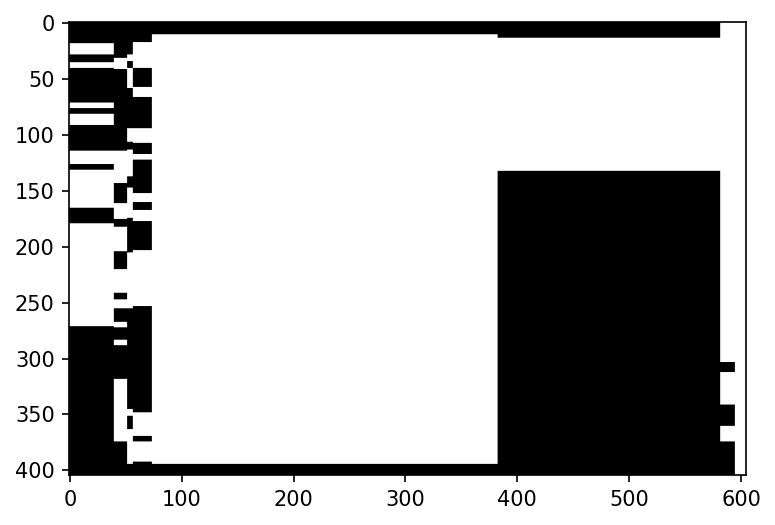

In [2111]:
plt.figure(dpi=150)
# plt.imshow(main_mask[:, :, 0], cmap='gray')
plt.imshow(main_mask, cmap='gray')

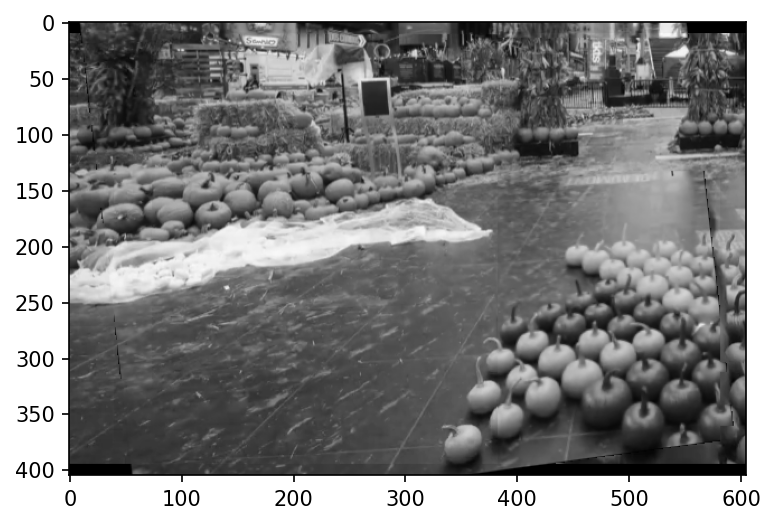

In [2112]:
show(res, dpi=150, disable_axis=False)

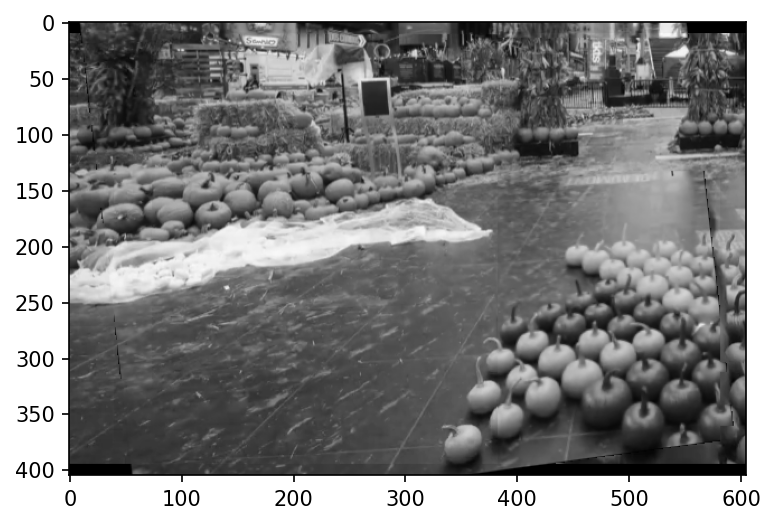

In [2113]:
show(res, dpi=150, disable_axis=False)

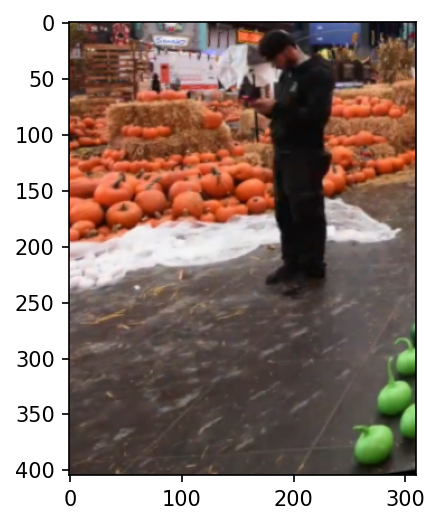

In [1907]:
show(i1[:, 80:390], dpi=150, disable_axis=False)

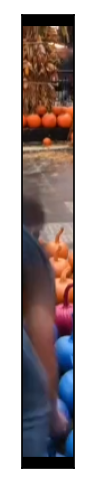

In [1908]:
show(i2[:, 558:604], dpi=150)

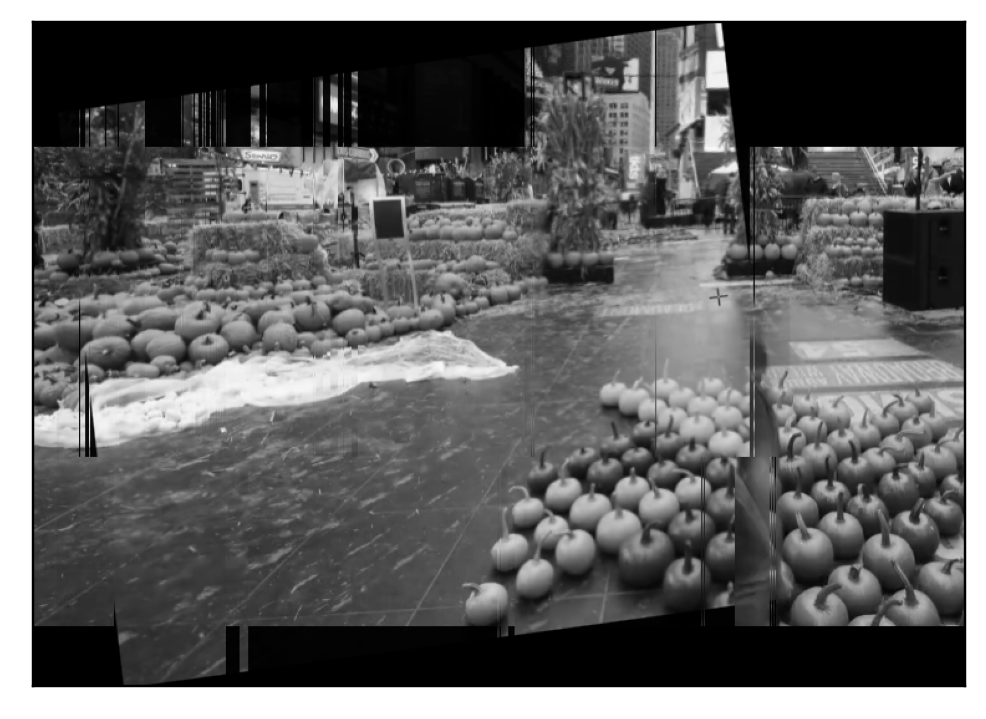

In [573]:
def merge(img1, img2, window_sz, p=0.8):
    h, w = img1.shape
    res = np.zeros((h, w), dtype=np.uint8)
    
    for i in range(w):
        if (img1[:, i] == 0.0).all():
            res[:, i] = img2[:, i]
        elif (img2[:, i] == 0.0).all():
            res[:, i] = img1[:, i]
        else:
            if i == 0:
                res[:, i] = img1[:, i]
            else:
                for j in range(0, h, window_sz):
                    i1w = img1[j:j+window_sz, i]
                    i2w = img2[j:j+window_sz, i]
                    prev_res_w = res[j:j+window_sz, i-1]
                    
                    d1 = np.abs(i1w - prev_res_w).mean()
                    d2 = np.abs(i2w - prev_res_w).mean()
                    
                    if d1 < d2:
                        res[j:j+window_sz, i] = (p * i1w) + ((1-p) * i2w)
                    else:
                        res[j:j+window_sz, i] = (p * i2w) + ((1-p) * i1w)
            
    return res
    
x = merge(result, temp, img1.shape[0], 0.95)
show(x, dpi=220)

In [1239]:
result.shape, result.transpose((1,0,2)).shape

((535, 749, 3), (749, 535, 3))

In [1247]:
main_mask[...,None].shape

(405, 605, 1)

In [1246]:
np.tile(main_mask[...,None],3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)